https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        625M         24G        964K        630M         24G
Swap:            0B          0B          0B


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [ ]:
#load dataset

def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

In [ ]:
#tokenizer

def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
#max length

def max_length(lines):
	return max(len(line.split()) for line in lines)

In [ ]:
#encoding and pading

def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

In [ ]:
# one hot encode target sequence

def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [ ]:
# define NMT model

def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# load datasets
dataset = load_clean_sentences('/content/drive/MyDrive/NLP/NMT/Marathi-English/Cleaned Dataset/qed_raw_dataset.pkl')
train = load_clean_sentences('/content/drive/MyDrive/NLP/NMT/Marathi-English/Cleaned Dataset/qed_train.pkl')
test = load_clean_sentences('/content/drive/MyDrive/NLP/NMT/Marathi-English/Cleaned Dataset/qed_test.pkl')

In [ ]:
dataset=dataset.drop(dataset.index[0])

In [ ]:
print(dataset)

                                                Marathi                                            English
1                एक शेतकरी ५३१ टमाटे उगवतो, तीन दिवसात.  a farmer grows 531 tomatoes and is able to sel...
2     आता ज़र सांगितले असेल कि टमाटान ची आवक १७६ नि क...  given that his supply of tomatoes decreases by...
3                                        (सारंगी संगीत)                                     (violin music)
4                                       (संगीत समाप्ति)                                       (music ends)
5     शुभ प्रभात. आज मी इकडे आलोय ते स्वयंचलित, उडणा...  good morning. i'm here today to talk about aut...
...                                                 ...                                                ...
1741  आपण मध्ययुगातून पाहू. आणि आपल्या पुढच्या भागात...  we'll see through the middle ages, and then in...
1742  मी कॅटलीन प्रिएम, धार्मिक अभ्यासात द्विपदवीधार...  caitlin priem, religious studies major, and i ...
1743  शिशिर ऋतूत मी पदवीधारक होण्यासा

In [ ]:
# prepare marathi tokenizer

mar_tokenizer = create_tokenizer(dataset["Marathi"])
mar_vocab_size = len(mar_tokenizer.word_index) + 1
mar_length = max_length(dataset["Marathi"])
print('Marathi Vocabulary Size: %d' % mar_vocab_size)
print('Marathi Max Length: %d' % (mar_length))

Marathi Vocabulary Size: 26497
Marathi Max Length: 1210


In [ ]:
# prepare english tokenizer

eng_tokenizer = create_tokenizer(dataset["English"])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset["English"])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 6286
English Max Length: 365


In [ ]:
train['Marathi']

0       aata aaplya kade general tools aahet konchyahi...
1                  एक शेतकरी ५३१ टमाटे उगवतो, तीन दिवसात.
2       आता ज़र सांगितले असेल कि टमाटान ची आवक १७६ नि क...
3                                          (सारंगी संगीत)
4                                         (संगीत समाप्ति)
                              ...                        
1295    JAWS येथे एका आदर्श स्त्रीला भेटल्यावर तिने या...
1296       तर दुसऱ्या करवी दुसरा, त्याचा वेगळा ठसा असतो .
1297    सर्व मुद्दे मांडल्यानेच तुम्हाला वास्तव कळते. ...
1298                                       [The Guardian]
1299    मेगन कामेरिक : तुम्ही सर्व सहमत असाल पूर्ण माह...
Name: Marathi, Length: 1300, dtype: object

In [ ]:
train['English']

0       we now have the general tools to really tackle...
1       a farmer grows 531 tomatoes and is able to sel...
2       given that his supply of tomatoes decreases by...
3                                          (violin music)
4                                            (music ends)
                              ...                        
1295    one of my board members is an editor at a majo...
1296    seen from another point of view, it gives quit...
1297    but it's only when you get the whole picture, ...
1298                                       [the guardian]
1299    megan kamerick: i think you'll all agree that ...
Name: English, Length: 1300, dtype: object

In [ ]:
# prepare training data

trainX = encode_sequences(mar_tokenizer, mar_length, train["Marathi"])
trainY = encode_sequences(eng_tokenizer, eng_length, train["English"])
trainY = encode_output(trainY, eng_vocab_size)

In [ ]:
trainX

array([[ 2027,  7891,  6371, ...,     0,     0,     0],
       [    6,  4731,  6400, ...,     0,     0,     0],
       [   31, 10440,   291, ...,     0,     0,     0],
       ...,
       [   60,  1904, 23006, ...,     0,     0,     0],
       [ 3016, 23007,     0, ...,     0,     0,     0],
       [23008, 23009,    13, ...,     0,     0,     0]], dtype=int32)

In [ ]:
trainY

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [ ]:
# prepare validation data

testX = encode_sequences(mar_tokenizer, mar_length, test["Marathi"])
testY = encode_sequences(eng_tokenizer, eng_length, test["English"])
testY = encode_output(testY, eng_vocab_size)

In [ ]:
# define model

model = define_model(mar_vocab_size, eng_vocab_size, mar_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 256)         6783232   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 365, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 365, 256)          525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 365, 6286)         1615502   
Total params: 9,449,358
Trainable params: 9,449,358
Non-trainable params: 0
_________________________________________________________________
None


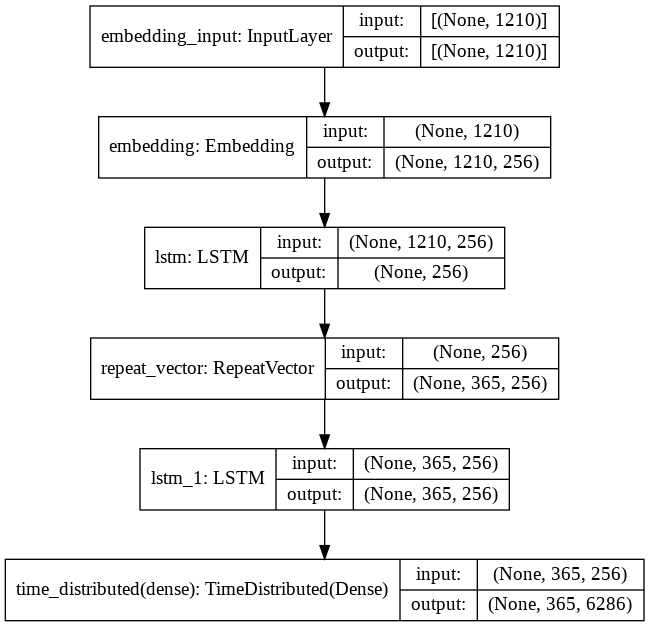

In [ ]:
# summarize defined model

print(model.summary())
plot_model(model, to_file='/content/drive/MyDrive/NLP/NMT/Marathi-English/model/qed/model.png', show_shapes=True)

In [ ]:
# fit model

filename = '/content/drive/MyDrive/NLP/NMT/Marathi-English/model/qed/model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/30
21/21 - 26s - loss: 4.8651 - val_loss: 0.7394

Epoch 00001: val_loss improved from inf to 0.73936, saving model to /content/drive/MyDrive/NLP/NMT/Marathi-English/model/qed/model.h5
Epoch 2/30
21/21 - 14s - loss: 0.7928 - val_loss: 0.7207

Epoch 00002: val_loss improved from 0.73936 to 0.72075, saving model to /content/drive/MyDrive/NLP/NMT/Marathi-English/model/qed/model.h5
Epoch 3/30
21/21 - 14s - loss: 0.7602 - val_loss: 0.6840

Epoch 00003: val_loss improved from 0.72075 to 0.68400, saving model to /content/drive/MyDrive/NLP/NMT/Marathi-English/model/qed/model.h5
Epoch 4/30
21/21 - 13s - loss: 0.6900 - val_loss: 0.5962

Epoch 00004: val_loss improved from 0.68400 to 0.59623, saving model to /content/drive/MyDrive/NLP/NMT/Marathi-English/model/qed/model.h5
Epoch 5/30
21/21 - 14s - loss: 0.6547 - val_loss: 0.5614

Epoch 00005: val_loss improved from 0.59623 to 0.56136, saving model to /content/drive/MyDrive/NLP/NMT/Marathi-English/model/qed/model.h5
Epoch 6/30
21/21 - 14s -